In [10]:
dataset_url = '../data/image_classification/'

In [11]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

## Load data

In [12]:
data = pd.read_csv(dataset_url + 'train.csv', on_bad_lines='skip')
data.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [13]:
data.shape

(29996, 3)

## Data exploration

In [6]:
# Transformer la target multi-classes en liste
data['Targets'] = data['Labels'].apply(lambda x: x.split(' '))
data.head()

,ImageID,Labels,Caption,Targets
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,[1]
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,"[1, 19]"
2,2.jpg,1,They are brave for riding in the jungle on tho...,[1]
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,"[8, 3, 13]"
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,"[8, 3, 7]"


Classes found: ['1' '19' '8' '3' '13' '7' '5' '4' '18' '15' '6' '9' '17' '10' '2' '16'
 '14' '11']


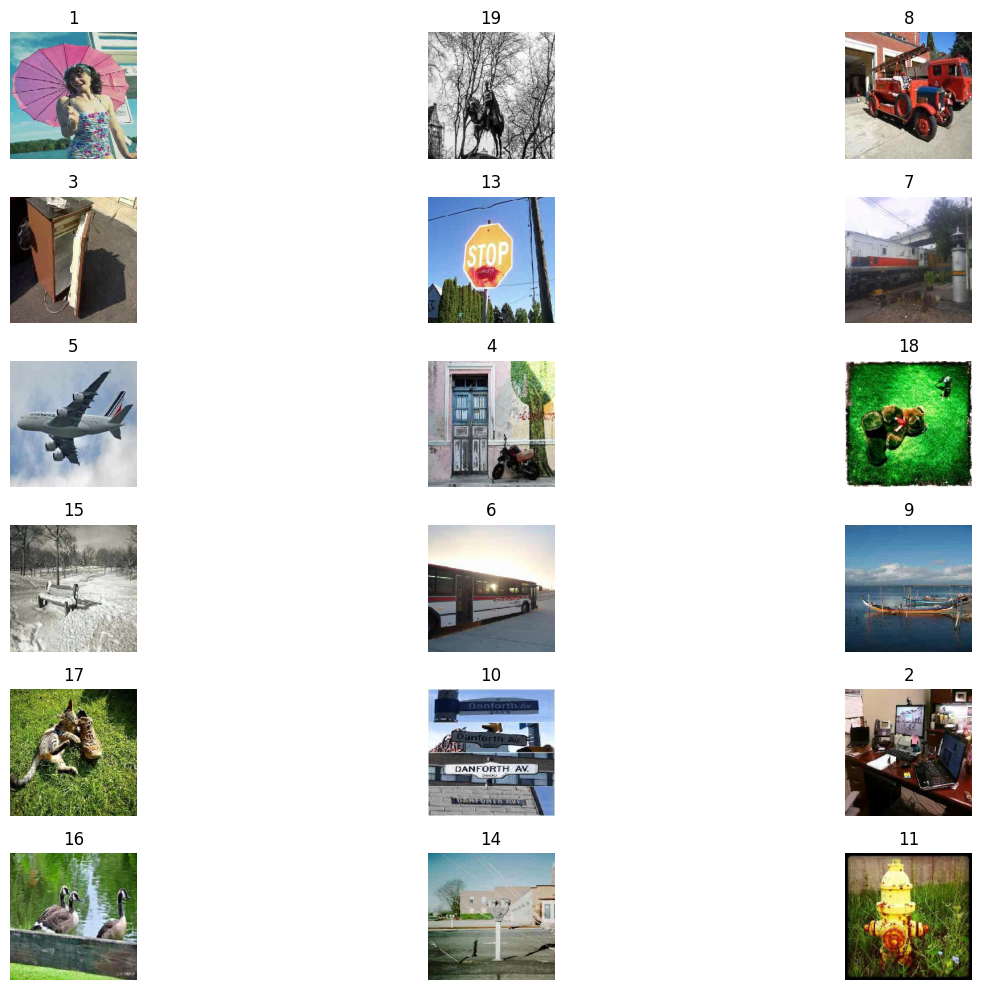

In [55]:
# List classes available in the dataset
classes = data['Targets'].explode().unique()
print("Classes found:", classes)

num_cols = 3
num_rows = 6

plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    image = data[data['Targets'].apply(lambda x: x==[cls])]
    if not image.empty:
        img = load_img(dataset_url + 'data/' + image.iloc[0]['ImageID'], target_size=(224, 224))
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        
        plt.savefig('../output/visualize_classes.png')
    
plt.tight_layout()
plt.show()

In [15]:
# Liste des classes et leurs nombres d'occurences quand ils sont uniques
data[data['Targets'].apply(len) == 1].groupby(data['Targets'].apply(lambda x: str(x))).count()

,ImageID,Labels,Caption,Targets
Targets,,,,
['1'],14073,14073,14073,14073
['10'],186,186,186,186
['11'],187,187,187,187
['13'],200,200,200,200
['14'],42,42,42,42
['15'],289,289,289,289
['16'],673,673,673,673
['17'],975,975,975,975
['18'],585,585,585,585


* Gros desequilibre au niveau des classes
* On va faire une augmentation de données pour les classes minoritaires

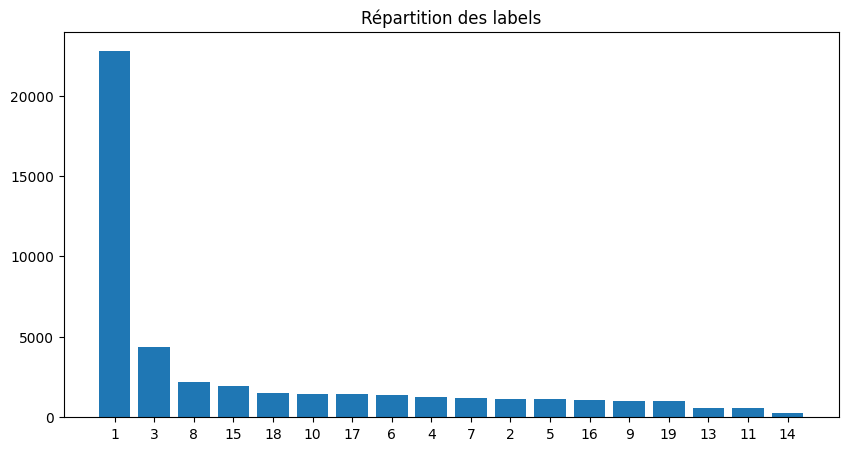

In [16]:
label_counts = pd.DataFrame(data['Targets'].explode().value_counts()).reset_index()
label_counts.columns = ['Label', 'Count']
label_counts['Proportion'] = label_counts['Count'] / label_counts['Count'].sum()

plt.figure(figsize=(10, 5))
plt.bar(label_counts['Label'], label_counts['Count'])
plt.title('Répartition des labels')
plt.show()

In [17]:
label_counts

,Label,Count,Proportion
0,1,22794,0.489856
1,3,4364,0.093785
2,8,2210,0.047494
3,15,1934,0.041563
4,18,1525,0.032773
5,10,1470,0.031591
6,17,1430,0.030732
7,6,1395,0.029979
8,4,1272,0.027336
9,7,1221,0.026240


In [18]:
# temp = data[data.apply(lambda x: '1' not in x['Targets'], axis=1)]  # Supprime toutes les lignes avec '1' dans les targets
temp = data[data.apply(lambda x: x['Targets'] != ['1'], axis=1)] # Supprime toutes les lignes avec seulement '1' comme target

temp['Targets'].explode().value_counts()

Targets
1     8721
3     4364
8     2210
15    1934
18    1525
10    1470
17    1430
6     1395
4     1272
7     1221
2     1164
5     1132
16    1099
9     1042
19    1020
13     605
11     603
14     252
Name: count, dtype: int64

## Data preprocessing

* Split les données en train, val et test
* Augmenter les données pour les classes minoritaires dans l'ensemble de train

In [14]:
temp = data.copy()
temp.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [15]:
train_len = 0.7
val_len = 0.15
test_len = 0.15
random_state = 42

# Création du DataFrame
df = pd.DataFrame(temp)

# Conversion des labels en listes d'entiers
df['Labels'] = df['Labels'].apply(lambda x: list(map(int, x.split())))

# Séparation des features et des labels
X = df[['ImageID', 'Caption']]
y = df['Labels']

# Conversion des labels en format binaire (multilabel-indicator)
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Division stratifiée en ensembles d'entraînement et de test
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_len, random_state=random_state)
for train_index, test_index in msss.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]

# Division de l'ensemble d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_len/(train_len+val_len), random_state=random_state)

# Affichage des tailles des ensembles
print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (21004, 2)
Validation size: (4501, 2)
Test size: (4491, 2)


In [16]:
# Convertir en DataFrame
y_train_df = pd.DataFrame(y_train, columns=mlb.classes_)
y_val_df = pd.DataFrame(y_val, columns=mlb.classes_)
y_test_df = pd.DataFrame(y_test, columns=mlb.classes_)

# Assurer l'alignement des index
X_train.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)

X_val.reset_index(drop=True, inplace=True)
y_val_df.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Concaténation propre
train_data = pd.concat([X_train, y_train_df], axis=1)
val_data = pd.concat([X_val, y_val_df], axis=1)
test_data = pd.concat([X_test, y_test_df], axis=1)

# Vérifier la taille finale
train_data.shape, val_data.shape, test_data.shape

((21004, 20), (4501, 20), (4491, 20))

In [9]:
train_data.head()

,ImageID,Caption,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,21999.jpg,A couple of men standing next to a train on a ...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,10911.jpg,An empty bench sits next to a river.,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11565.jpg,Three people in orange vests watch a space shu...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23495.jpg,A traffic light with a street sigh hanging fro...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,26902.jpg,A man standing on a tennis court holding a rac...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


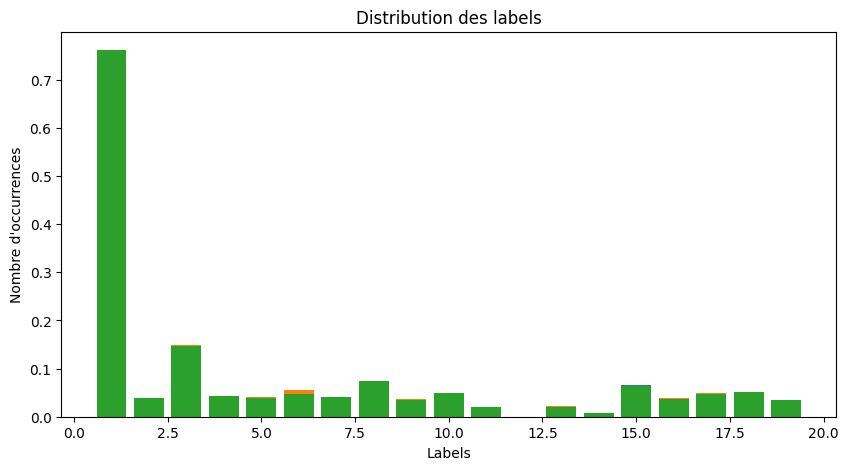

In [ ]:
# Calculer la distribution des labels
label_distribution = train_data.iloc[:, 2:].sum()
label_distribution_val = val_data.iloc[:, 2:].sum()
label_distribution_test = test_data.iloc[:, 2:].sum()

# Afficher la distribution des labels
plt.figure(figsize=(10, 5))
plt.bar(label_distribution.index, label_distribution.values/len(train_data), alpha=0.7, label='Train', color='blue')
plt.bar(label_distribution_val.index, label_distribution_val.values/len(val_data), alpha=0.7, label='Validation', color='green')
plt.bar(label_distribution_test.index, label_distribution_test.values/len(test_data), alpha=0.7, label='Test', color='red')
plt.title('Distribution des labels')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import albumentations as A
import cv2
from functools import partial
from tqdm import tqdm


class MultiLabelDataAugmentation:
    def __init__(self, 
                 dataset_path: str, 
                 df: pd.DataFrame, 
                 output_path: str,
                 num_workers: int = None):

        self.dataset_path = dataset_path
        self.output_path = output_path
        
        # Définir le nombre de workers (défaut: nombre de coeurs disponibles - 1)
        self.num_workers = num_workers or (os.cpu_count() - 1)
        
        # Charger les labels
        self.labels_df = df.copy()
        
        # Créer le dossier de sortie s'il n'existe pas
        os.makedirs(output_path, exist_ok=True)
    
    def safe_load_image(self, image_path: str) -> np.ndarray:
        try:
            # Charger l'image en couleur
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            if image is None:
                raise ValueError(f"Impossible de charger l'image {image_path}")
            
            # Convertir de BGR à RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            return image
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {image_path}: {e}")
            return None
    
    def create_safe_transforms(self, image: np.ndarray) -> A.Compose:
        height, width = image.shape[:2]
        
        # Stratégies pour les petites images
        transforms_list = []
        
        # 1. Si l'image est très petite, on évite le crop
        if height < 224 or width < 224:
            transforms_list.extend([
                A.PadIfNeeded(
                    min_height=224, 
                    min_width=224, 
                    border_mode=cv2.BORDER_CONSTANT, 
                    value=[0, 0, 0]  # Padding noir
                ),
                A.Resize(height=224, width=224)
            ])
        else:
            # Pour les images plus grandes
            transforms_list.extend([
                A.RandomCrop(height=min(height, 224), width=min(width, 224)),
                A.Resize(height=224, width=224)
            ])
        
        # Transformations communes
        transforms_list.extend([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.3),
            A.Perspective(p=0.3)
        ])
        
        return A.Compose(transforms_list)
    
    def extraire_labels_minoritaires(self, 
                                     seuil_pourcentage: float = 10) -> List[int]:
        # Colonnes de labels (excluant 'ImageID' et 'Caption')
        label_columns = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption']]
        label_percentages = self.labels_df[label_columns].sum() / len(self.labels_df) * 100
        
        return [label for label, percentage in label_percentages.items() if percentage < seuil_pourcentage]
    
    def augmenter_image_unique(self, row: pd.Series, nb_augmentations: int = 5) -> List[Dict]:
        """
        Augmente une seule image et retourne les informations des images augmentées
        """
        image_path = os.path.join(self.dataset_path, row['ImageID'])
        
        # Charger l'image de manière sécurisée
        image = self.safe_load_image(image_path)
        
        if image is None:
            return []
        
        # Créer des transformations sécurisées
        transforms = self.create_safe_transforms(image)
        
        augmentations_resultats = []
        
        # Générer des augmentations
        for i in range(nb_augmentations):
            try:
                augmented = transforms(image=image)
                augmented_image = augmented['image']
                
                # Nom de fichier pour l'image augmentée
                nom_base = os.path.splitext(row['ImageID'])[0]
                nouveau_nom = f"{nom_base}_aug_{i+1}.jpg"
                chemin_sortie = os.path.join(self.output_path, nouveau_nom)
                
                # Sauvegarder l'image
                cv2.imwrite(chemin_sortie, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                
                # Préparer les données pour le nouveau DataFrame 
                nouvelle_ligne = row.copy()
                nouvelle_ligne['ImageID'] = nouveau_nom
                
                augmentations_resultats.append(nouvelle_ligne)
            
            except Exception as e:
                print(f"Erreur lors de l'augmentation de {row['ImageID']}: {e}")
        
        return augmentations_resultats
    
    def augmenter_labels_minoritaires(self, 
                                      seuil_pourcentage: float = 10, 
                                      nb_augmentations: int = 5):
        
        # Identifier les labels minoritaires
        labels_minoritaires = self.extraire_labels_minoritaires(seuil_pourcentage)
        print("Labels minoritaires identifiés :", labels_minoritaires)
        labels_majoritaires = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption'] and col not in labels_minoritaires]
        
        # Filtrer les images avec les labels minoritaires
        images_minoritaires = self.labels_df[
            (self.labels_df[labels_minoritaires].sum(axis=1) > 0) & (self.labels_df[labels_majoritaires].sum(axis=1) == 0)
        ]
        
        # Augmentation sans multiprocessing
        nouvelles_images = []
        for index, row in tqdm(images_minoritaires.iterrows(), total=len(images_minoritaires), desc="Augmentation des images"):
            # print(f"Traitement de l'image {row['ImageID']} ({index+1}/{len(images_minoritaires)})")
            augmentations = self.augmenter_image_unique(row)
            nouvelles_images.extend(augmentations)
        
        if nouvelles_images:
            self.labels_df = pd.concat([self.labels_df, pd.DataFrame(nouvelles_images)], ignore_index=True)
        
        # Sauvegarder le nouveau CSV
        self.labels_df.to_csv(os.path.join(self.output_path, 'augmented_labels.csv'), index=False)
        
        print(f"Augmentation terminée. {len(self.labels_df)} images dans le nouveau dataset.")
    
    def calculer_repartition_labels(self) -> Dict[str, float]:
        label_columns = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption']]
        label_percentages = self.labels_df[label_columns].sum() / len(self.labels_df) * 100
        
        return label_percentages.to_dict()

In [24]:
# Exemple d'utilisation
augmenteur = MultiLabelDataAugmentation(
    dataset_path=dataset_url+'data', 
    df=train_data,
    output_path='../augmented_images/train',
    num_workers=1  # Utilise automatiquement le nombre de coeurs disponibles - 1
)

# Afficher la répartition des labels
print("Répartition des labels :")
print(augmenteur.calculer_repartition_labels())

# Augmenter les labels minoritaires
augmenteur.augmenter_labels_minoritaires(
    seuil_pourcentage=20,  # Labels avec moins de 5% des données 
    nb_augmentations=15     # 5 augmentations par image
)

Répartition des labels :
{1: 76.11407350980765, 2: 3.946867263378404, 3: 14.45915063797372, 4: 4.218244143972576, 5: 3.680251380689392, 6: 4.470577032946106, 7: 4.075414206817749, 8: 7.370024757189107, 9: 3.442201485431346, 10: 4.922871833936393, 11: 2.01390211388307, 13: 1.9900971243572652, 14: 0.852218625023805, 15: 6.5416111216911075, 16: 3.6231194058274614, 17: 4.713387926109312, 18: 5.099028756427347, 19: 3.446962483336508}
Labels minoritaires identifiés : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]


Augmentation des images:   0%|          | 0/5017 [00:00<?, ?it/s]

C:\Users\jforc\AppData\Local\Temp\ipykernel_71540\2594743412.py:55: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
Augmentation des images: 100%|██████████| 5017/5017 [02:24<00:00, 34.78it/s]


Augmentation terminée. 46089 images dans le nouveau dataset.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

def visualiser_augmentations(
    dataset_path: str, 
    csv_augmente_path: str, 
    output_path: str = None
):
    """
    Visualise les images originales et leurs augmentations pour chaque label.
    
    :param dataset_path: Chemin du dossier contenant les images originales
    :param csv_augmente_path: Chemin du CSV généré après augmentation
    :param output_path: Chemin de sauvegarde optionnel des visualisations
    """
    # Charger le CSV augmenté
    df_augmente = pd.read_csv(csv_augmente_path)
    
    # Colonnes de labels (excluant 'ImageID' et 'Caption')
    label_columns = [col for col in df_augmente.columns if col not in ['ImageID', 'Caption']]
    
    # Créer un dossier de sortie si spécifié
    if output_path:
        os.makedirs(output_path, exist_ok=True)
    
    # Pour chaque label
    for label in label_columns:
        # Trouver les augmentations de ce label
        df_label = df_augmente[df_augmente[label] == 1]
        
        # Images originales vs augmentées
        originales = df_label[~df_label['ImageID'].str.contains('aug')]
        augmentees = df_label[df_label['ImageID'].str.contains('aug')]
        
        # Associer les originales et leurs augmentations
        matched_pairs = []
        for _, orig_row in originales.iterrows():
            base_name = os.path.splitext(orig_row['ImageID'])[0]
            aug_matching = augmentees[augmentees['ImageID'].str.startswith(base_name + '_aug')]
            
            for _, aug_row in aug_matching.iterrows():
                matched_pairs.append((orig_row['ImageID'], aug_row['ImageID']))
        
        # Limiter à 5 paires maximum
        matched_pairs = matched_pairs[:2]
        
        # Visualisation
        plt.figure(figsize=(15, 3 * len(matched_pairs)))
        plt.suptitle(f'Augmentations pour le label "{label}"', fontsize=16)
        
        for i, (orig_name, aug_name) in enumerate(matched_pairs):
            # Charger image originale
            orig_path = os.path.join('../data/image_classification/data', orig_name)
            orig_image = cv2.imread(orig_path)
            orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
            
            # Charger image augmentée
            aug_path = os.path.join(os.path.dirname(csv_augmente_path), aug_name)
            aug_image = cv2.imread(aug_path)
            aug_image = cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB)
            
            # Afficher l'image originale
            plt.subplot(len(matched_pairs), 2, i*2 + 1)
            plt.title('Image Originale')
            plt.imshow(orig_image)
            plt.axis('off')
            
            # Afficher l'image augmentée
            plt.subplot(len(matched_pairs), 2, i*2 + 2)
            plt.title('Image Augmentée')
            plt.imshow(aug_image)
            plt.axis('off')
        
        # Sauvegarder ou afficher
        if output_path:
            plt.savefig(output_path+f'augmentations_{label}.png')
            plt.close()
        else:
            plt.show()

# Exemple d'utilisation
visualiser_augmentations(
    dataset_path='../augmented_images/train',
    csv_augmente_path='../augmented_images/train/augmented_labels.csv',
    output_path='../output'
)

In [ ]:
train = pd.read_csv('../augmented_images/train/augmented_labels.csv')

,ImageID,Caption,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,21999.jpg,A couple of men standing next to a train on a ...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,10911.jpg,An empty bench sits next to a river.,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11565.jpg,Three people in orange vests watch a space shu...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23495.jpg,A traffic light with a street sigh hanging fro...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,26902.jpg,A man standing on a tennis court holding a rac...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


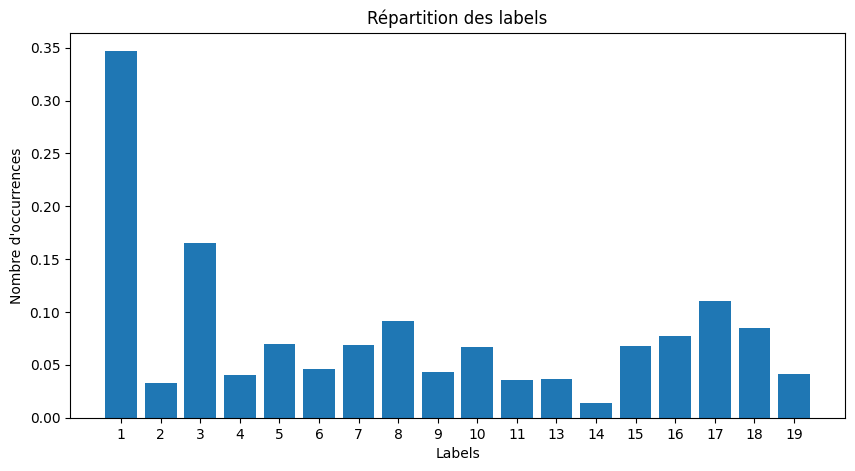

In [ ]:
label_counts = train.iloc[:, 2:].sum()

# Afficher la répartition des labels
plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values/len(train))
plt.title('Répartition des labels')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.show()

## Modeling

In [19]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

class MemoryEfficientMultiLabelDataset:
    def __init__(self, csv_path, image_dir, target_size=(224, 224), df=None):
        """
        Initialise le dataset multi-labels avec chargement paresseux
        
        Paramètres:
        - csv_path: Chemin vers le fichier CSV
        - image_dir: Répertoire contenant les images
        - target_size: Taille de redimensionnement des images
        """
        self.csv_path = csv_path
        self.image_dir = image_dir
        self.target_size = target_size
        
        # Charger les données
        print("Chargement des données...")
        if df is not None:
            self.df = pd.DataFrame(df)
        else:
            self.df = pd.read_csv(csv_path)
        print(f"Nombre total d'images: {len(self.df)}")
        
        # Colonnes de labels (exclure 'ImageID' et 'Caption')
        self.label_columns = [col for col in self.df.columns if col not in ['ImageID', 'Caption']]
    
    def _parse_image(self, image_filename, labels):
        """
        Charge et prétraite une image depuis un fichier
        
        Paramètres:
        - image_filename: Nom du fichier image
        - labels: Labels associés
        
        Retourne:
        - Image prétraitée, labels
        """
        # Gestion conditionnelle des chemins d'image
        if '_aug' in image_filename:
            image_path = os.path.join(self.image_dir, image_filename)
        else:
            image_path = os.path.join('../data/image_classification/data', image_filename)
        
        # Lire l'image
        img = Image.open(image_path).convert('RGB')
        
        # Redimensionner
        img_resized = img.resize(self.target_size, Image.LANCZOS)
        
        # Convertir en tensor TensorFlow et normaliser
        img_tensor = tf.keras.preprocessing.image.img_to_array(img_resized)
        img_tensor /= 255.0
        
        return img_tensor, labels
    
    def create_dataset(self, batch_size=32, shuffle=True):
        """
        Crée un dataset TensorFlow avec chargement à la volée
        
        Paramètres:
        - batch_size: Taille des batchs
        - shuffle: Mélanger les données
        
        Retourne:
        - Dataset TensorFlow
        """
        print("Préparation du dataset TensorFlow...")
        
        # Convertir les chemins d'images et labels en tensors
        image_filenames = tf.constant(self.df['ImageID'].values)
        labels = tf.constant(self.df[self.label_columns].values, dtype=tf.float32)
        
        # Créer un dataset initial
        dataset = tf.data.Dataset.from_tensor_slices((image_filenames, labels))
        
        # Appliquer le parsing des images
        dataset = dataset.map(
            lambda x, y: tf.py_function(
                self._parse_image, [x, y], [tf.float32, tf.float32]
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Mélanger le dataset
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(self.df))
        
        # Création des batchs
        dataset = dataset.batch(batch_size)
        
        # Optimisation
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        print("Dataset TensorFlow créé.")
        return dataset
    
    def print_dataset_info(self):
        """
        Affiche des informations sur le dataset
        """
        print("Informations sur le Dataset:")
        print("-" * 30)
        print(f"Nombre total d'images: {len(self.df)}")
        print(f"Taille des images: {self.target_size}")
        print(f"Nombre de classes: {len(self.label_columns)}")
        
        # Distribution des labels
        print("\nDistribution des labels:")
        label_sums = self.df[self.label_columns].sum()
        for label, count in label_sums.items():
            print(f"{label}: {count} (proportion: {count/len(self.df):.2%})")

In [24]:
# Chemins à adapter
csv_path = '../augmented_images/train/augmented_labels.csv'
image_dir = '../augmented_images/train/'

# Initialiser le dataset
dataset = MemoryEfficientMultiLabelDataset(csv_path, image_dir)

# Afficher les informations du dataset
dataset.print_dataset_info()

# Créer les datasets TensorFlow
train_dataset = dataset.create_dataset(batch_size=32)

Chargement des données...
Nombre total d'images: 46089
Informations sur le Dataset:
------------------------------
Nombre total d'images: 46089
Taille des images: (224, 224)
Nombre de classes: 18

Distribution des labels:
1: 15987 (proportion: 34.69%)
2: 1529 (proportion: 3.32%)
3: 7627 (proportion: 16.55%)
4: 1846 (proportion: 4.01%)
5: 3213 (proportion: 6.97%)
6: 2134 (proportion: 4.63%)
7: 3181 (proportion: 6.90%)
8: 4198 (proportion: 9.11%)
9: 2013 (proportion: 4.37%)
10: 3079 (proportion: 6.68%)
11: 1628 (proportion: 3.53%)
13: 1693 (proportion: 3.67%)
14: 644 (proportion: 1.40%)
15: 3109 (proportion: 6.75%)
16: 3556 (proportion: 7.72%)
17: 5100 (proportion: 11.07%)
18: 3906 (proportion: 8.47%)
19: 1904 (proportion: 4.13%)
Préparation du dataset TensorFlow...
Dataset TensorFlow créé.


In [25]:
image_dir = '../augmented_images/train/'

# Initialiser le dataset
val_set = MemoryEfficientMultiLabelDataset(csv_path, image_dir, df=val_data)

# Afficher les informations du dataset
val_set.print_dataset_info()

# Créer les datasets TensorFlow
val_dataset = dataset.create_dataset(batch_size=32)

Chargement des données...
Nombre total d'images: 4501
Informations sur le Dataset:
------------------------------
Nombre total d'images: 4501
Taille des images: (224, 224)
Nombre de classes: 18

Distribution des labels:
1: 3387 (proportion: 75.25%)
2: 160 (proportion: 3.55%)
3: 672 (proportion: 14.93%)
4: 195 (proportion: 4.33%)
5: 189 (proportion: 4.20%)
6: 247 (proportion: 5.49%)
7: 182 (proportion: 4.04%)
8: 330 (proportion: 7.33%)
9: 163 (proportion: 3.62%)
10: 215 (proportion: 4.78%)
11: 90 (proportion: 2.00%)
13: 96 (proportion: 2.13%)
14: 35 (proportion: 0.78%)
15: 270 (proportion: 6.00%)
16: 173 (proportion: 3.84%)
17: 225 (proportion: 5.00%)
18: 225 (proportion: 5.00%)
19: 143 (proportion: 3.18%)
Préparation du dataset TensorFlow...
Dataset TensorFlow créé.


In [26]:
# Exemple de modèle simple (à personnaliser)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(dataset.label_columns), activation='sigmoid')
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['roc-auc']
)

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Entraînement (exemple)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None